In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
import geojson
import geopandas as gpd
import planetary_computer
import pyproj
import shapely.wkt
import rasterio
from rasterio import features, warp, windows
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import Point, Polygon, shape, MultiPolygon
from pyproj import CRS
from pystac_client.client import Client

In [2]:
def get_items(geojson_geometry):
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=geojson_geometry,
        datetime="2023-01-01/2023-02-28",
        limit=1  # Ajuste conforme necessário
    )
    items = list(search.get_items())
    
    return items
    

In [3]:
def generate_geojson(wkt):
    geometry = shapely.wkt.loads(wkt)
    geojson_geometry = shapely.geometry.mapping(geometry)

    return geojson_geometry

def get_band_info(href, area):
    shapely_geometry = shape(area)
    print(href)
    with rasterio.open(href) as ds:
        warped_geometry = warp.transform_geom(
            "EPSG:4326", ds.crs, shapely_geometry
        )
        _, out_transform = mask(ds, [warped_geometry], crop=True)

        return {
            "transform": out_transform, #transformação do recorte
            "crs": int(f"{ds.crs}".split(":")[1]), #epsg do raster
        }

def raster(href, wkt):
    shapely_geometry = shape(wkt) #Transforma uma geometria WKT (wkt) em uma geometria Shapely
    with rasterio.open(href) as ds: #bre um arquivo raster (href)
        warped_geometry = warp.transform_geom(
            "EPSG:4326", ds.crs, shapely_geometry    #Transforma a geometria para a mesma projeção do raster
        )
        out_image, _ = mask(ds, [warped_geometry], crop=True) #Aplica uma máscara ao raster com a geometria transformada

    return out_image

def get_area_square_meters(area):
    if area["type"] == "Polygon":
        polygon = Polygon(area["coordinates"][0])
    elif area["type"] == "MultiPolygon":
        polygons = [Polygon(coords[0]) for coords in area["coordinates"]]
        polygon = MultiPolygon(polygons)
    else:
        raise ValueError("O tipo de geometria não é suportado")

    utm_zone = 23
    utm_proj = f"+proj=utm +zone={utm_zone} +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    gdf = gpd.GeoDataFrame({"geometry": [polygon]}, crs="EPSG:4326")
    projected_gdf = gdf.to_crs(crs=utm_proj)

    return projected_gdf["geometry"].area.values[0]

def round_percentage(no_cloud_cover: float) -> float:
    if no_cloud_cover > 1.0:
        return round(no_cloud_cover, 2)
    else:
        return no_cloud_cover

def get_cloud_cover_percentage(matrix_scl, geometry):
    np.seterr(divide="ignore", invalid="ignore")
    valid_values = range(12)

    valid_pixels = matrix_scl[np.isin(matrix_scl, valid_values)]

    cloud_values = [4, 5, 6, 7]

    total_area = get_area_square_meters(geometry)

    no_cloud_pixel_values = np.count_nonzero(np.isin(valid_pixels, cloud_values))

    no_cloud_pixel_area = (
        no_cloud_pixel_values * 400
    )  # 400 == total area of pixel scl

    if valid_pixels.size == 0 | no_cloud_pixel_values == 0:
        return 0.0

    no_cloud_cover = no_cloud_pixel_area / total_area
    
    print(no_cloud_cover)

    no_cloud_cover = round_percentage(no_cloud_cover)

    return no_cloud_cover

In [4]:
def generate_images_ndvi(items, wkt):
    for image in items:
        band_red_href = image.assets['B04'].href
        band_nir_href = image.assets['B08'].href
        band_blue_href = image.assets['B02'].href
        band_green_href = image.assets['B03'].href
        band_scl = image.assets['SCL'].href  #Banda usada para varias coisas, inclusive identificar nuvem
        band_info = get_band_info(band_red_href, wkt)

        bands = {'band_red': raster(band_red_href, wkt)[0],
                 'band_nir': raster(band_nir_href, wkt)[0],
                 'band_green':raster(band_green_href, wkt)[0],
                 'band_blue':raster(band_blue_href, wkt)[0],
                 'band_scl': raster(band_scl, wkt)[0],
                 'transform': band_info["transform"],
                 'crs': band_info["crs"]}

        cloud_cover = get_cloud_cover_percentage(bands['band_scl'], wkt) # % de nuvem na imagem

        if cloud_cover < 1.0:
            continue

        ndvi_img = (bands["band_nir"] - bands["band_red"]) / (bands["band_nir"] + bands["band_red"]) #calculo NDVI 
        img_matriz = ndvi_img.astype("float64")

        #Matriz com as cores reais da imagem em RGB
        rgb = np.stack((bands['band_red'], bands['band_green'], bands['band_blue']), axis=0)

        new_crs = CRS.from_epsg(bands["crs"]) #projeção do sentinel
        transform = bands["transform"]

        with rasterio.open(
            'C:\\Users\\renan.granusso\\Desktop\\Teste\\rasters\\sentinel_img2.tif', 'w',
            driver="GTiff",
            width=img_matriz.shape[1],
            height=img_matriz.shape[0],
            count=1,
            dtype=img_matriz.dtype,
            crs=new_crs,
            transform=transform
        ) as dst:
            dst.write(img_matriz, 1)


        with rasterio.open("C:\\Users\\renan.granusso\\Desktop\\Teste\\rasters\\sentinel_img2_rgb.tif", "w",
                           driver="GTiff",
                           width=img_matriz.shape[1],
                           height=img_matriz.shape[0],
                           count=3,
                           dtype=rgb.dtype,
                           crs=new_crs,
                           transform=transform) as dst:

            dst.write(rgb[0], 1)  # Banda R
            dst.write(rgb[1], 2)  # Banda G
            dst.write(rgb[2], 3)  # Banda B
        break

    return new_crs     
    

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/23/K/KR/2023/02/23/S2A_MSIL2A_20230223T132231_N0400_R038_T23KKR_20230225T013802.SAFE/GRANULE/L2A_T23KKR_A040075_20230223T132230/IMG_DATA/R10m/T23KKR_20230223T132231_B04_10m.tif?st=2024-11-25T14%3A09%3A35Z&se=2024-11-26T14%3A54%3A35Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-11-26T14%3A03%3A28Z&ske=2024-12-03T14%3A03%3A28Z&sks=b&skv=2024-05-04&sig=DZ5w2rc%2BbaAjINnisTQOmefLV2c%2BGKbjELSIt/QlGHU%3D
0.0
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/K/HA/2023/02/23/S2A_MSIL2A_20230223T132231_N0400_R038_T22KHA_20230227T121038.SAFE/GRANULE/L2A_T22KHA_A040075_20230223T132230/IMG_DATA/R10m/T22KHA_20230223T132231_B04_10m.tif?st=2024-11-25T14%3A09%3A35Z&se=2024-11-26T14%3A54%3A35Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-11-26T14%3A03%3A28Z&ske=2024-12-03T14%3A03%3A28Z&

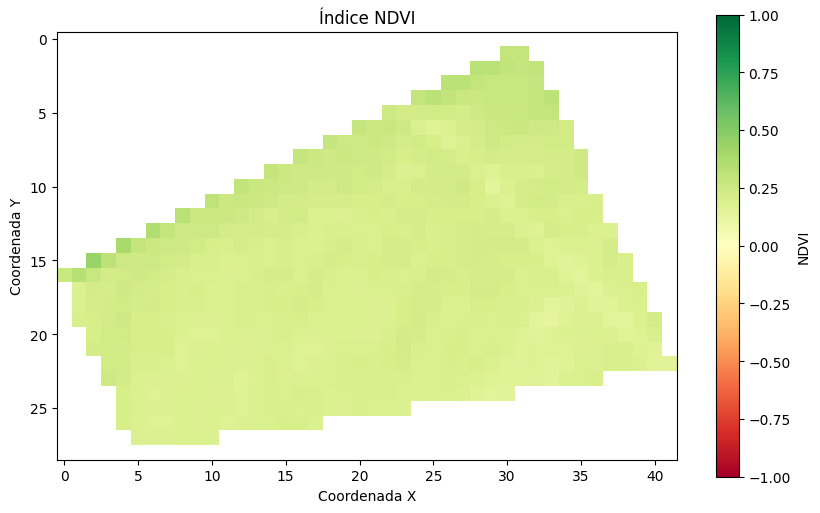

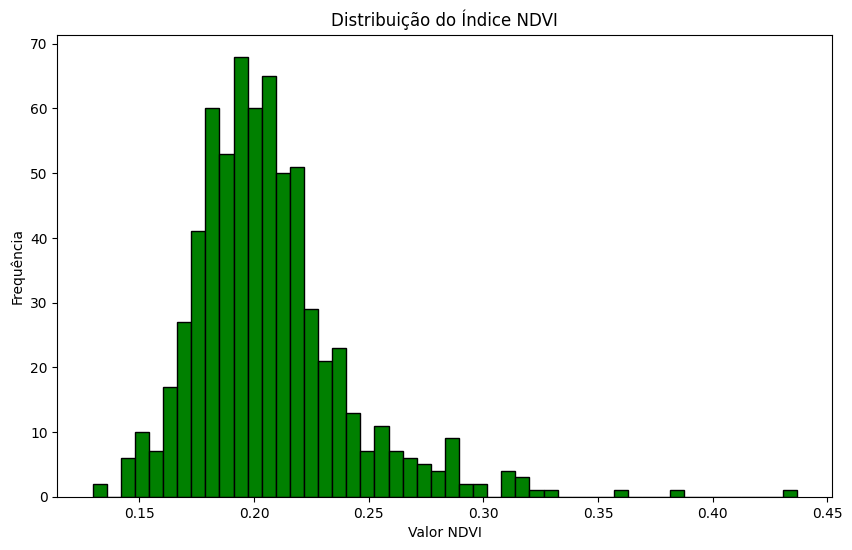

NDVI MEAN = 0.20638323353293406


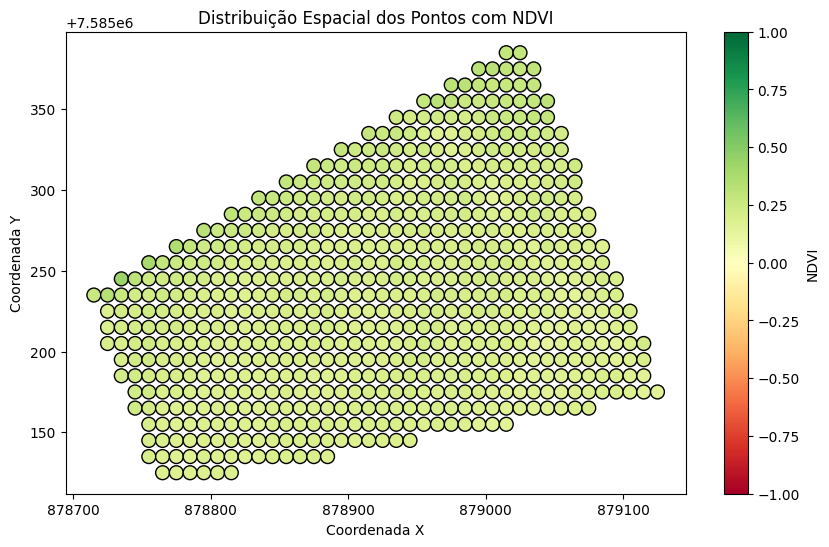

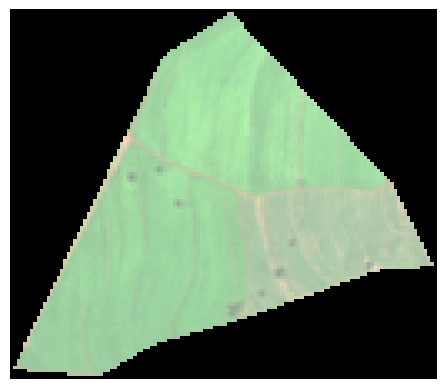

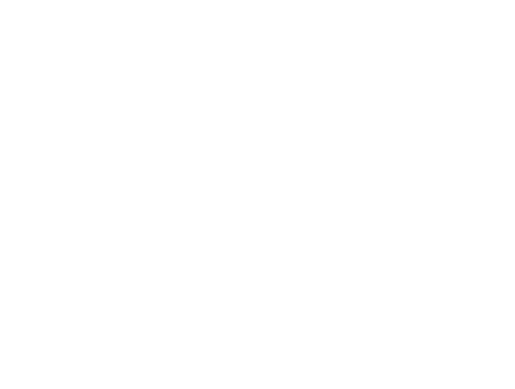

In [ ]:
wkt = "Polygon ((-47.33789688206950785 -21.79630489865338561, -47.33598534379766676 -21.79509346615510168, -47.33119132717937561 -21.79962924218886045, -47.32991696833147444 -21.8018266472608957, -47.3315857715846704 -21.80199567702404551, -47.33546953188302098 -21.80340425062632903, -47.33792722394683494 -21.80410853223273548, -47.33953534344536251 -21.80503817865020721, -47.34205371926383776 -21.8048973235203043, -47.33789688206950785 -21.79630489865338561))"
epsg = 4326

area = generate_geojson(wkt)
items = get_items(area)

crs = generate_images_ndvi(items, area) #gera imagens .tif

#Plotar os pontos em um gráfico

with rasterio.open('C:\\Users\\renan.granusso\\Desktop\\Teste\\rasters\\sentinel_img2_test.tif') as src:
    # Leia a primeira banda (presumindo que o NDVI esteja na primeira banda)
    ndvi = src.read(1)
    image_calculated = src.read(1)

    # Filtrar valores nodata e valores irrelevantes
    ndvi = np.where((ndvi >= -1) & (ndvi <= 1), ndvi, np.nan)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label="NDVI")
    plt.title("Índice NDVI")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.show()
    
    # Histograma dos valores de NDVI
    plt.figure(figsize=(10, 6))
    plt.hist(ndvi[~np.isnan(ndvi)], bins=50, color='green', edgecolor='black')
    plt.title("Distribuição do Índice NDVI")
    plt.xlabel("Valor NDVI")
    plt.ylabel("Frequência")
    plt.show()
    
    # Exibir valor NDVI de cada ponto e imprimir apenas uma amostra
    ndvi = np.where((ndvi >= -1) & (ndvi <= 1), ndvi, np.nan)
    n_linhas, n_colunas = ndvi.shape
    
    points = []
    pixel_count = 0 #contar os pixels para tirar a média
    media_sum = 0.0

    for linha in range(n_linhas):
        for coluna in range(n_colunas):
            valor_ndvi = ndvi[linha, coluna]
            bandwidth_value = round(image_calculated[linha, coluna], 3)

            if str(valor_ndvi) != 'nan':
                lon, lat = src.transform * (coluna + 0.5, linha + 0.5)
                point = {
                    "longitude": lon,
                    "latitude": lat,
                    "valor_ndvi": valor_ndvi
                }
                media_sum += bandwidth_value
                pixel_count += 1
                points.append(point)
    mean = str(float(media_sum / (pixel_count)))


x_coords = [lon['longitude'] for lon in points]
y_coords = [lat['latitude'] for lat in points]
ndvi_values = [ndvi['valor_ndvi'] for ndvi in points]

print("NDVI MEAN = " + str(mean)) #Media NDVI da imagem

plt.figure(figsize=(10, 6)) #define o tamanho da imagem

scatter = plt.scatter(x_coords, y_coords, c=ndvi_values, cmap='RdYlGn', s=100, edgecolor='k', vmin=-1, vmax=1)

plt.colorbar(scatter, label="NDVI")  # Barra de cor indicando valores NDVI

# Títulos e legendas
plt.title("Distribuição Espacial dos Pontos com NDVI")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")

plt.show()


#Plotar a imagem com as cores reais
with rasterio.open("C:\\Users\\renan.granusso\\Desktop\\Teste\\rasters\\sentinel_img2_rgb.tif") as src:
    # Verifique se a imagem tem múltiplas bandas (por exemplo, RGB)
    if src.count == 3:
        # Carregar as três bandas (verifique a ordem para sua imagem, pode ser RGB ou BGR)
        r, g, b = src.read(1), src.read(2), src.read(3)
        rgb = np.stack((r, g, b), axis=0)
        rgb = rgb / rgb.max()
        plt.imshow(np.transpose(rgb, (1, 2, 0)))  # Transponha para formato (altura, largura, canais)
        plt.axis('off')  # Remove os eixos
        plt.show()
    else:
        # Caso a imagem tenha apenas uma banda
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, cmap='gray')  # Exibe em tons de cinza

plt.axis('off')  # Remove os eixos
plt.show()

